In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report
import kagglehub
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Tải dataset về (sẽ trả về đường dẫn local)
path = kagglehub.dataset_download("bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024")

print("Dataset downloaded to:", path)

Dataset downloaded to: C:\Users\PC\.cache\kagglehub\datasets\bhavikjikadara\us-airline-flight-routes-and-fares-1993-2024\versions\1


In [116]:
df = pd.read_csv(path + "/US Airline Flight Routes and Fares 1993-2024.csv")
print(df.shape)
df.head()

(245955, 23)


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,...,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,...,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,...,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,...,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,...,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,...,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX


In [117]:
# ==================== 1. DATA CLEANING ====================
# Kiểm tra missing values
print(f"\n\nGiá trị thiếu theo cột:")
missing = df.isnull().sum()
missing_percent = 100 * missing / len(df)
missing_table = pd.DataFrame({
    'Missing_Count': missing,
    'Percent': missing_percent
})
print(missing_table[missing_table['Missing_Count'] > 0])



Giá trị thiếu theo cột:
                Missing_Count    Percent
carrier_lg               1540   0.626131
large_ms                 1540   0.626131
fare_lg                  1540   0.626131
carrier_low              1612   0.655404
lf_ms                    1612   0.655404
fare_low                 1612   0.655404
Geocoded_City1          39206  15.940314
Geocoded_City2          39206  15.940314


In [118]:
# Xử lý missing values
print("\n\nXử lý giá trị thiếu...")
# Điền giá trị thiếu cho các cột số bằng median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"  - Điền {col} bằng median")

# Điền giá trị thiếu cho các cột text bằng mode hoặc 'Unknown'
text_cols = df.select_dtypes(include=['object']).columns
for col in text_cols:
    if df[col].isnull().sum() > 0:
        if df[col].mode().shape[0] > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
            print(f"  - Điền {col} bằng mode")
        else:
            df[col].fillna('Unknown', inplace=True)
            print(f"  - Điền {col} bằng 'Unknown'")

# Loại bỏ duplicates
duplicates = df.duplicated().sum()
print(f"\n\nSố dòng trùng lặp: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Đã loại bỏ {duplicates} dòng trùng lặp")

# Kiểm tra và xử lý outliers cho các cột quan trọng
print("\n\nXử lý outliers...")
outlier_cols = ['passengers', 'fare', 'large_ms', 'lf_ms', 'fare_lg', 'fare_low']
for col in outlier_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 3 * IQR
        upper = Q3 + 3 * IQR
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        if outliers > 0:
            print(f"  - {col}: phát hiện {outliers} outliers")
            # Cap outliers thay vì loại bỏ
            df[col] = df[col].clip(lower=lower, upper=upper)

# Kiểm tra tính hợp lệ của dữ liệu
print("\n\nKiểm tra tính hợp lệ...")
# Market share phải từ 0-100
if 'large_ms' in df.columns:
    invalid_ms = ((df['large_ms'] < 0) | (df['large_ms'] > 100)).sum()
    print(f"  - large_ms không hợp lệ: {invalid_ms}")
    df = df[(df['large_ms'] >= 0) & (df['large_ms'] <= 100)]

if 'lf_ms' in df.columns:
    invalid_ms = ((df['lf_ms'] < 0) | (df['lf_ms'] > 100)).sum()
    print(f"  - lf_ms không hợp lệ: {invalid_ms}")
    df = df[(df['lf_ms'] >= 0) & (df['lf_ms'] <= 100)]

# Passengers và fare phải > 0
if 'passengers' in df.columns:
    df = df[df['passengers'] > 0]
if 'fare' in df.columns:
    df = df[df['fare'] > 0]

print(f"\n\nKích thước dữ liệu sau khi làm sạch: {df.shape}")



Xử lý giá trị thiếu...
  - Điền large_ms bằng median
  - Điền fare_lg bằng median
  - Điền lf_ms bằng median
  - Điền fare_low bằng median
  - Điền carrier_lg bằng mode
  - Điền carrier_low bằng mode
  - Điền Geocoded_City1 bằng mode
  - Điền Geocoded_City2 bằng mode


Số dòng trùng lặp: 0


Xử lý outliers...
  - passengers: phát hiện 12284 outliers
  - fare: phát hiện 857 outliers
  - fare_lg: phát hiện 786 outliers
  - fare_low: phát hiện 925 outliers


Kiểm tra tính hợp lệ...
  - large_ms không hợp lệ: 0
  - lf_ms không hợp lệ: 0


Kích thước dữ liệu sau khi làm sạch: (238516, 23)


In [119]:

# ==================== 2. EXPLORATORY DATA ANALYSIS ====================
print("\n" + "="*80)
print("BƯỚC 2: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)")
print("="*80)

# Thống kê mô tả
print("\n\nThống kê mô tả các biến số:")
print(df[numeric_cols].describe())


BƯỚC 2: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)


Thống kê mô tả các biến số:
                Year        quarter  citymarketid_1  citymarketid_2  \
count  238516.000000  238516.000000   238516.000000   238516.000000   
mean     2008.617594       2.482010    31556.478702    32175.443128   
std         8.672414       1.122017     1093.940628     1231.943367   
min      1993.000000       1.000000    30135.000000    30189.000000   
25%      2001.000000       1.000000    30721.000000    30977.000000   
50%      2009.000000       2.000000    31295.000000    32211.000000   
75%      2016.000000       3.000000    32467.000000    33192.000000   
max      2024.000000       4.000000    35412.000000    35628.000000   

         airportid_1    airportid_2        nsmiles     passengers  \
count  238516.000000  238516.000000  238516.000000  238516.000000   
mean    12436.939715   13239.666890    1189.284308     270.087508   
std      1430.439257    1425.274798     698.992628     355.415816   
min     1013

In [120]:
# Phân tích thị phần
print("\n\n--- PHÂN TÍCH THỊ PHẦN ---")

# 1. Thị phần trung bình theo carrier
if 'carrier_lg' in df.columns and 'large_ms' in df.columns:
    carrier_ms = df.groupby('carrier_lg')['large_ms'].agg(['mean', 'median', 'std', 'count'])
    carrier_ms = carrier_ms.sort_values('mean', ascending=False)
    print("\n1. Thị phần trung bình của các carrier lớn:")
    print(carrier_ms.head(10))

# 2. Thị phần theo thời gian
if 'Year' in df.columns and 'quarter' in df.columns:
    time_ms = df.groupby(['Year', 'quarter'])['large_ms'].agg(['mean', 'std', 'count'])
    print("\n2. Thị phần trung bình theo thời gian (5 kỳ gần nhất):")
    print(time_ms.tail())

# 3. Phân tích theo tuyến đường
if 'city1' in df.columns and 'city2' in df.columns:
    df['route'] = df['city1'] + ' - ' + df['city2']
    route_analysis = df.groupby('route').agg({
        'large_ms': 'mean',
        'passengers': 'sum',
        'fare': 'mean'
    }).sort_values('passengers', ascending=False)
    print("\n3. Top 10 tuyến đường theo số hành khách:")
    print(route_analysis.head(10))




--- PHÂN TÍCH THỊ PHẦN ---

1. Thị phần trung bình của các carrier lớn:
                mean  median       std  count
carrier_lg                                   
E9          1.000000    1.00  0.000000      3
P9          0.999878    1.00  0.001104     82
U5          0.936452    1.00  0.160199    124
G4          0.873460    1.00  0.218045   2127
PN          0.873333    1.00  0.235578     12
XJ          0.870000    0.87       NaN      1
9K          0.866667    1.00  0.230940      3
U2          0.825000    0.81  0.038079     10
WV          0.817705    0.93  0.206675     61
BF          0.784444    0.81  0.120531      9

2. Thị phần trung bình theo thời gian (5 kỳ gần nhất):
                  mean       std  count
Year quarter                           
2023 1        0.694837  0.220802   1886
     2        0.701973  0.220919   1910
     3        0.710285  0.217038   1948
     4        0.710669  0.216928   1912
2024 1        0.709661  0.215357   1870

3. Top 10 tuyến đường theo số hành kh

In [121]:
# 4. Phân tích cạnh tranh
print("\n4. Phân tích mức độ cạnh tranh:")
competition = df.groupby(['carrier_lg', 'carrier_low']).size().reset_index(name='count')
competition = competition.sort_values('count', ascending=False)
print(f"  - Số cặp carrier cạnh tranh: {len(competition)}")
print("  - Top 10 cặp cạnh tranh nhiều nhất:")
print(competition.head(10))


4. Phân tích mức độ cạnh tranh:
  - Số cặp carrier cạnh tranh: 585
  - Top 10 cặp cạnh tranh nhiều nhất:
    carrier_lg carrier_low  count
552         WN          WN  38990
11          AA          AA  17485
495         US          US  11127
144         DL          DL   9785
456         UA          UA   7668
101         CO          CO   6460
16          AA          DL   5673
430         UA          AA   5143
45          AA          WN   4969
138         DL          AA   4713


In [122]:

# 5. Tương quan giữa các biến
print("\n5. Ma trận tương quan giữa các biến quan trọng:")
corr_cols = ['passengers', 'fare', 'large_ms', 'lf_ms', 'nsmiles', 'fare_lg', 'fare_low']
corr_cols = [c for c in corr_cols if c in df.columns]
correlation = df[corr_cols].corr()
print(correlation)


5. Ma trận tương quan giữa các biến quan trọng:
            passengers      fare  large_ms     lf_ms   nsmiles   fare_lg  \
passengers    1.000000 -0.223820 -0.033462 -0.110782 -0.106970 -0.166275   
fare         -0.223820  1.000000 -0.217991 -0.234359  0.549792  0.957690   
large_ms     -0.033462 -0.217991  1.000000  0.510489 -0.412536 -0.212438   
lf_ms        -0.110782 -0.234359  0.510489  1.000000 -0.260408 -0.284523   
nsmiles      -0.106970  0.549792 -0.412536 -0.260408  1.000000  0.518265   
fare_lg      -0.166275  0.957690 -0.212438 -0.284523  0.518265  1.000000   
fare_low     -0.257997  0.862621 -0.123583  0.025088  0.455508  0.808822   

            fare_low  
passengers -0.257997  
fare        0.862621  
large_ms   -0.123583  
lf_ms       0.025088  
nsmiles     0.455508  
fare_lg     0.808822  
fare_low    1.000000  




--- TẠO BIỂU ĐỒ TRỰC QUAN ---


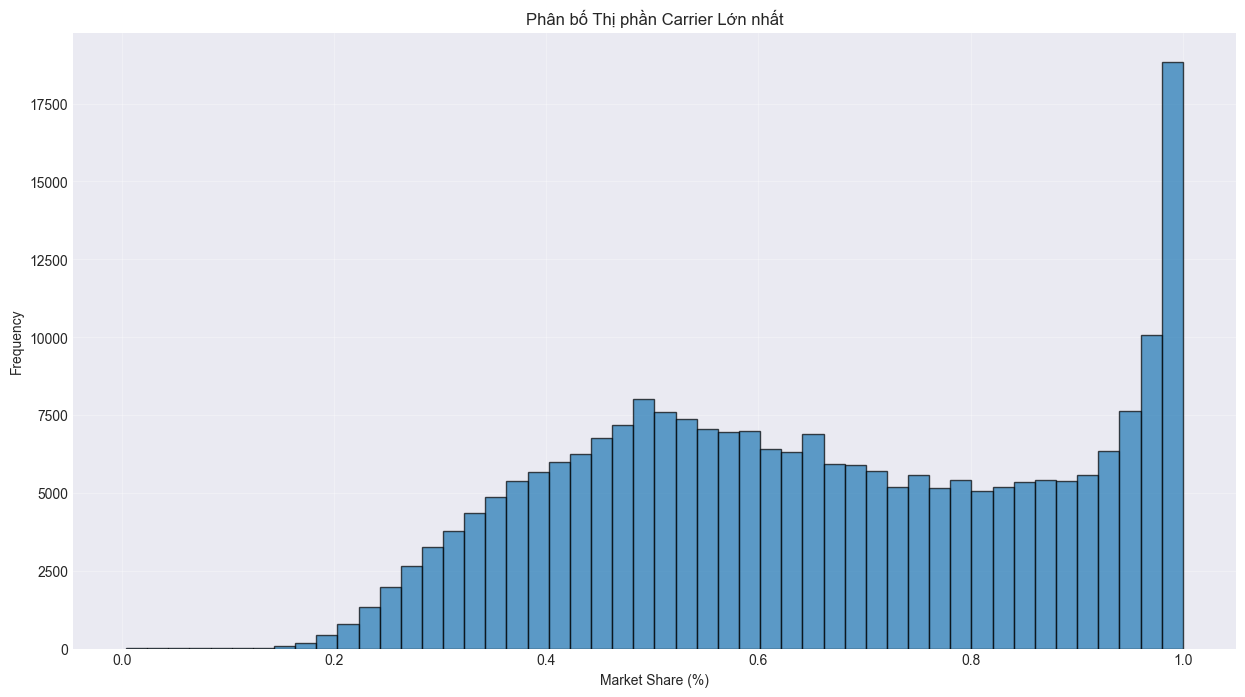

In [123]:
# ==================== 3. TRỰC QUAN HÓA ====================
print("\n\n--- TẠO BIỂU ĐỒ TRỰC QUAN ---")

# 1. Phân bố thị phần
if 'large_ms' in df.columns:
    plt.figure(figsize=(15, 8))
    plt.hist(df['large_ms'], bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Market Share (%)')
    plt.ylabel('Frequency')
    plt.title('Phân bố Thị phần Carrier Lớn nhất')
    plt.grid(True, alpha=0.3)

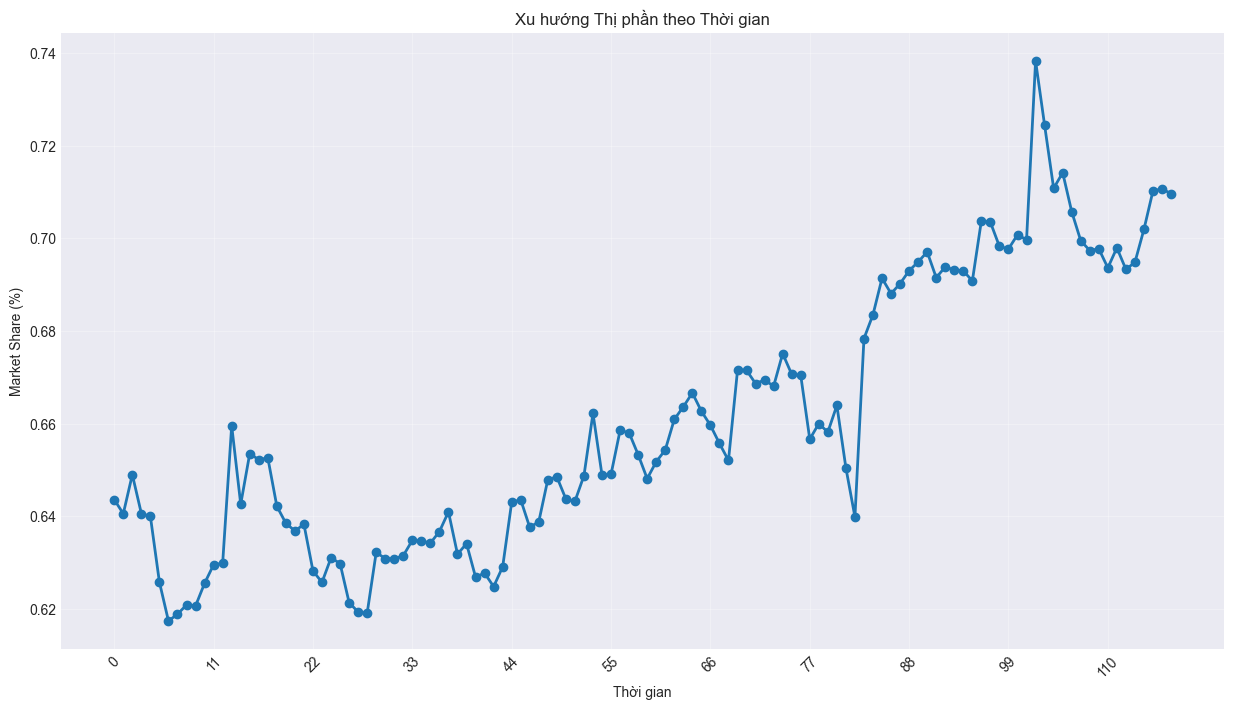

In [124]:
# 2. Thị phần theo thời gian
if 'Year' in df.columns and 'quarter' in df.columns and 'large_ms' in df.columns:
    plt.figure(figsize=(15, 8))
    time_trend = df.groupby(['Year', 'quarter'])['large_ms'].mean().reset_index()
    time_trend['period'] = time_trend['Year'].astype(str) + '-Q' + time_trend['quarter'].astype(str)
    plt.plot(range(len(time_trend)), time_trend['large_ms'], marker='o', linewidth=2)
    plt.xlabel('Thời gian')
    plt.ylabel('Market Share (%)')
    plt.title('Xu hướng Thị phần theo Thời gian')
    plt.xticks(range(0, len(time_trend), max(1, len(time_trend)//10)), rotation=45)
    plt.grid(True, alpha=0.3)

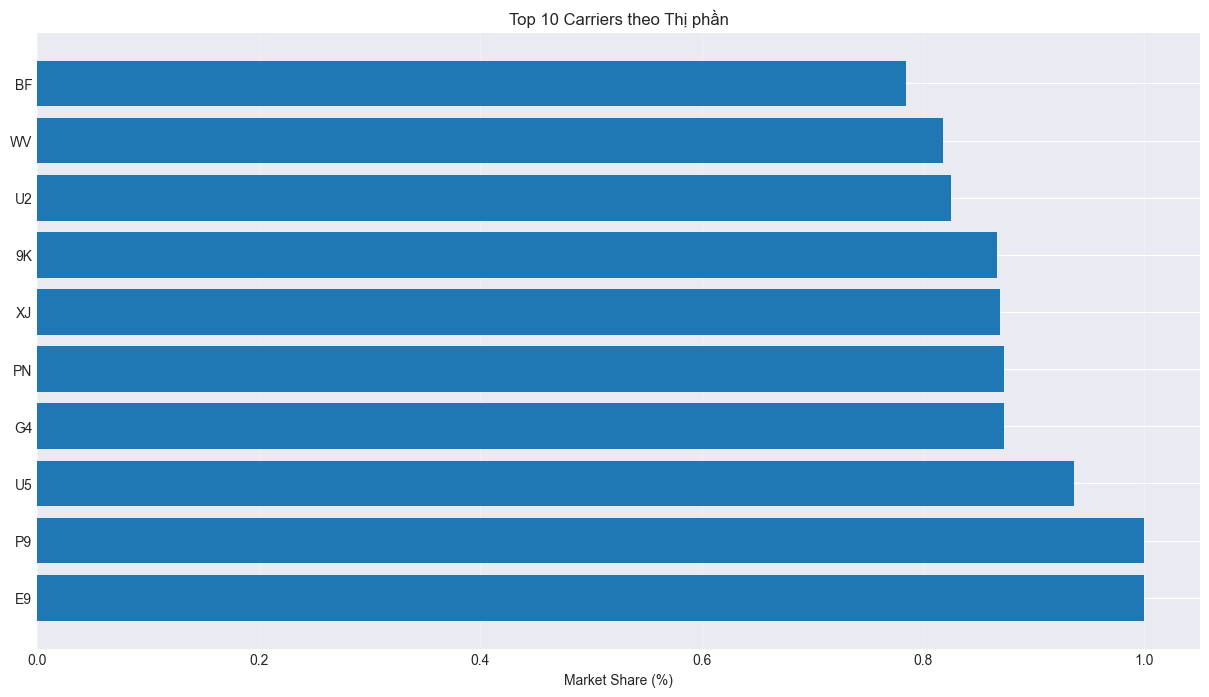

In [125]:
# 3. Top carriers theo thị phần
if 'carrier_lg' in df.columns and 'large_ms' in df.columns:
    plt.figure(figsize=(15, 8))
    top_carriers = df.groupby('carrier_lg')['large_ms'].mean().sort_values(ascending=False).head(10)
    plt.barh(range(len(top_carriers)), top_carriers.values)
    plt.yticks(range(len(top_carriers)), top_carriers.index)
    plt.xlabel('Market Share (%)')
    plt.title('Top 10 Carriers theo Thị phần')
    plt.grid(True, alpha=0.3, axis='x')

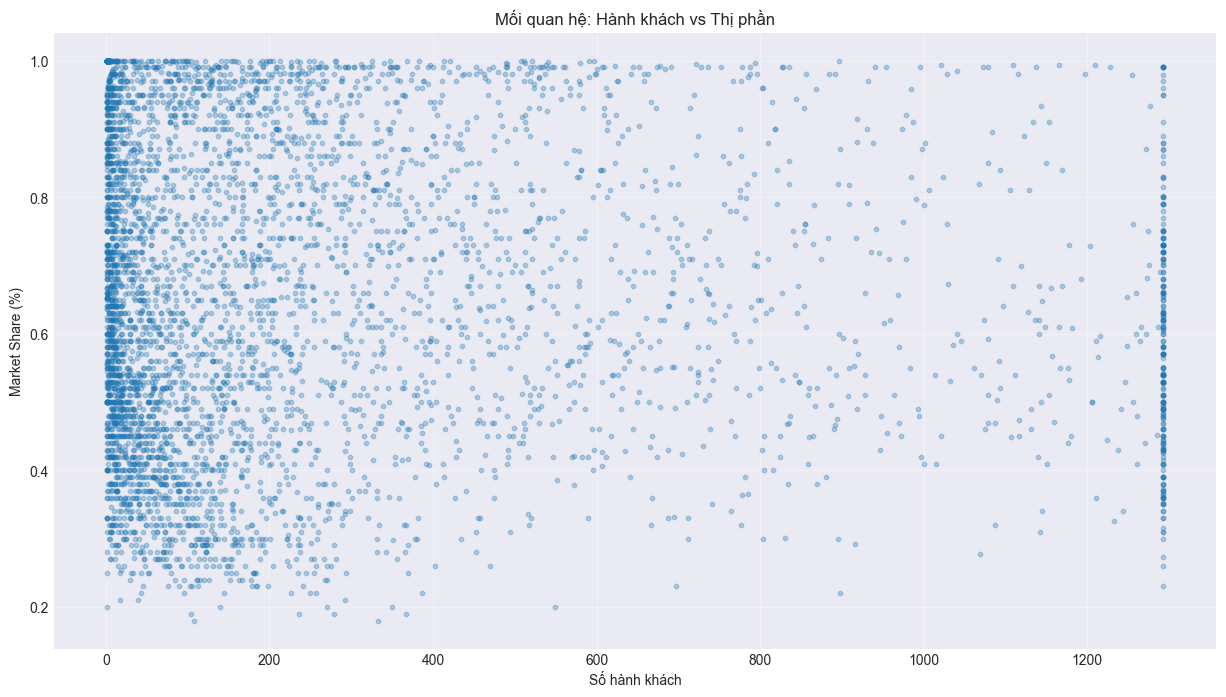

In [126]:
# 4. Scatter: Passengers vs Market Share
if 'passengers' in df.columns and 'large_ms' in df.columns:
    plt.figure(figsize=(15, 8))
    sample = df.sample(min(5000, len(df)))
    plt.scatter(sample['passengers'], sample['large_ms'], alpha=0.3, s=10)
    plt.xlabel('Số hành khách')
    plt.ylabel('Market Share (%)')
    plt.title('Mối quan hệ: Hành khách vs Thị phần')
    plt.grid(True, alpha=0.3)

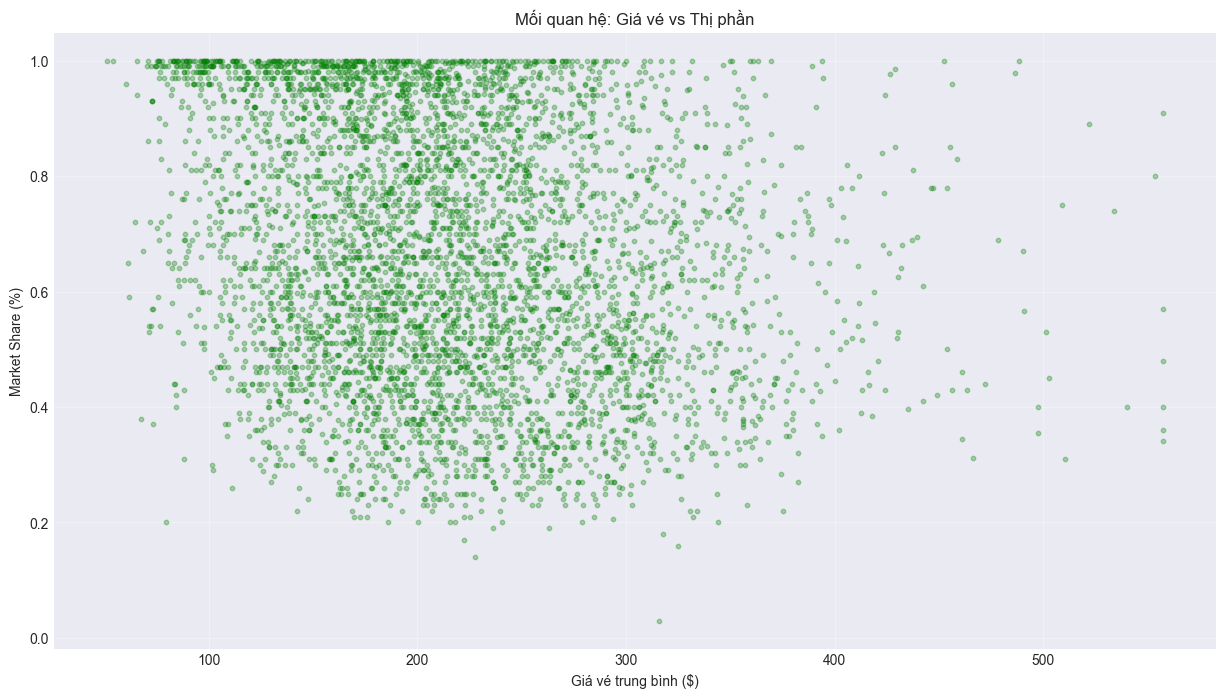

In [127]:
# 5. Scatter: Fare vs Market Share
if 'fare' in df.columns and 'large_ms' in df.columns:
    plt.figure(figsize=(15, 8))
    sample = df.sample(min(5000, len(df)))
    plt.scatter(sample['fare'], sample['large_ms'], alpha=0.3, s=10, color='green')
    plt.xlabel('Giá vé trung bình ($)')
    plt.ylabel('Market Share (%)')
    plt.title('Mối quan hệ: Giá vé vs Thị phần')
    plt.grid(True, alpha=0.3)

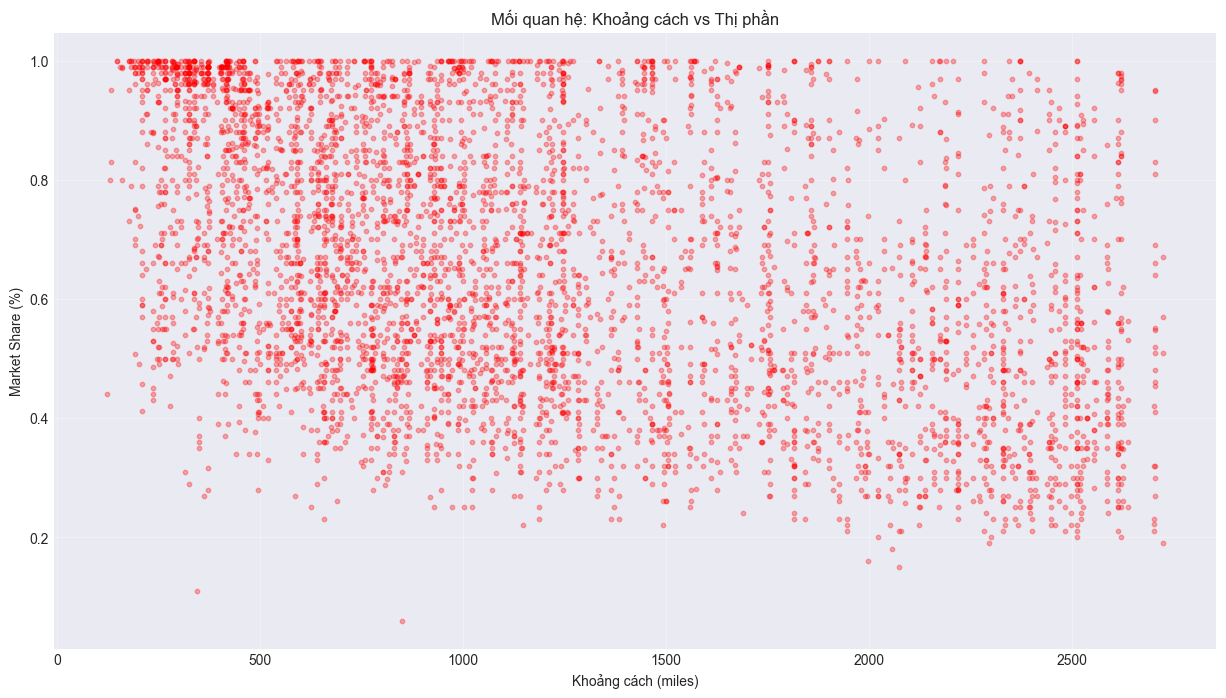

In [128]:
# 6. Scatter: Distance vs Market Share
if 'nsmiles' in df.columns and 'large_ms' in df.columns:
    plt.figure(figsize=(15, 8))
    sample = df.sample(min(5000, len(df)))
    plt.scatter(sample['nsmiles'], sample['large_ms'], alpha=0.3, s=10, color='red')
    plt.xlabel('Khoảng cách (miles)')
    plt.ylabel('Market Share (%)')
    plt.title('Mối quan hệ: Khoảng cách vs Thị phần')
    plt.grid(True, alpha=0.3)

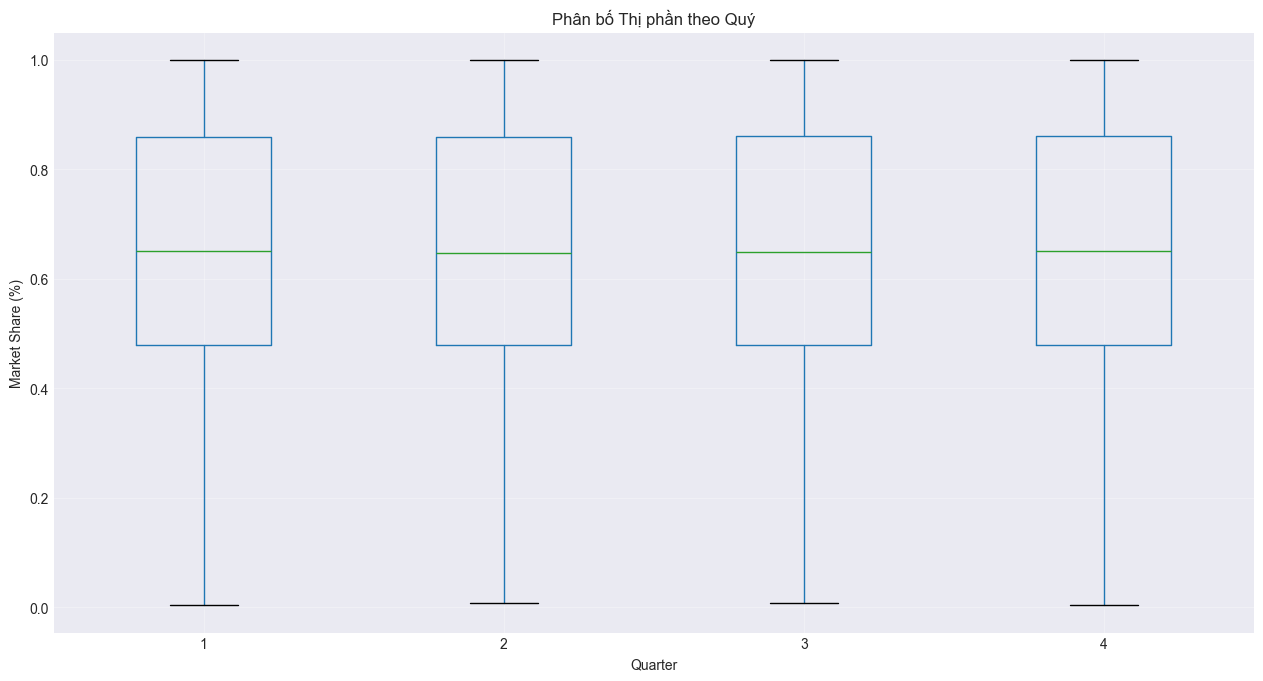

In [129]:
# 7. Boxplot: Market Share by Quarter
if 'quarter' in df.columns and 'large_ms' in df.columns:
    plt.figure(figsize=(15, 8))
    df.boxplot(column='large_ms', by='quarter', ax=plt.gca())
    plt.xlabel('Quarter')
    plt.ylabel('Market Share (%)')
    plt.title('Phân bố Thị phần theo Quý')
    plt.suptitle('')
    plt.grid(True, alpha=0.3)

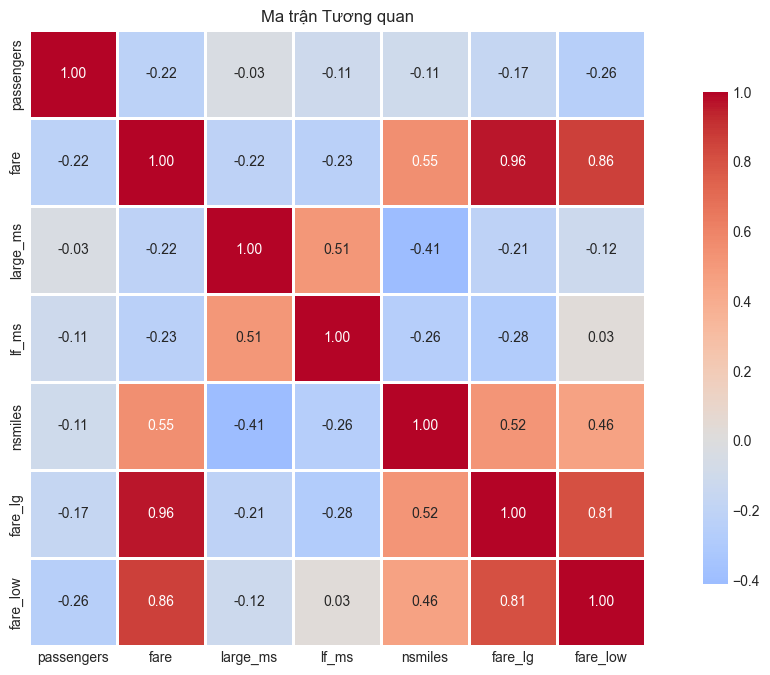

In [130]:
 #8. Heatmap tương quan
plt.figure(figsize=(15, 8))
if len(corr_cols) > 0:
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Ma trận Tương quan')

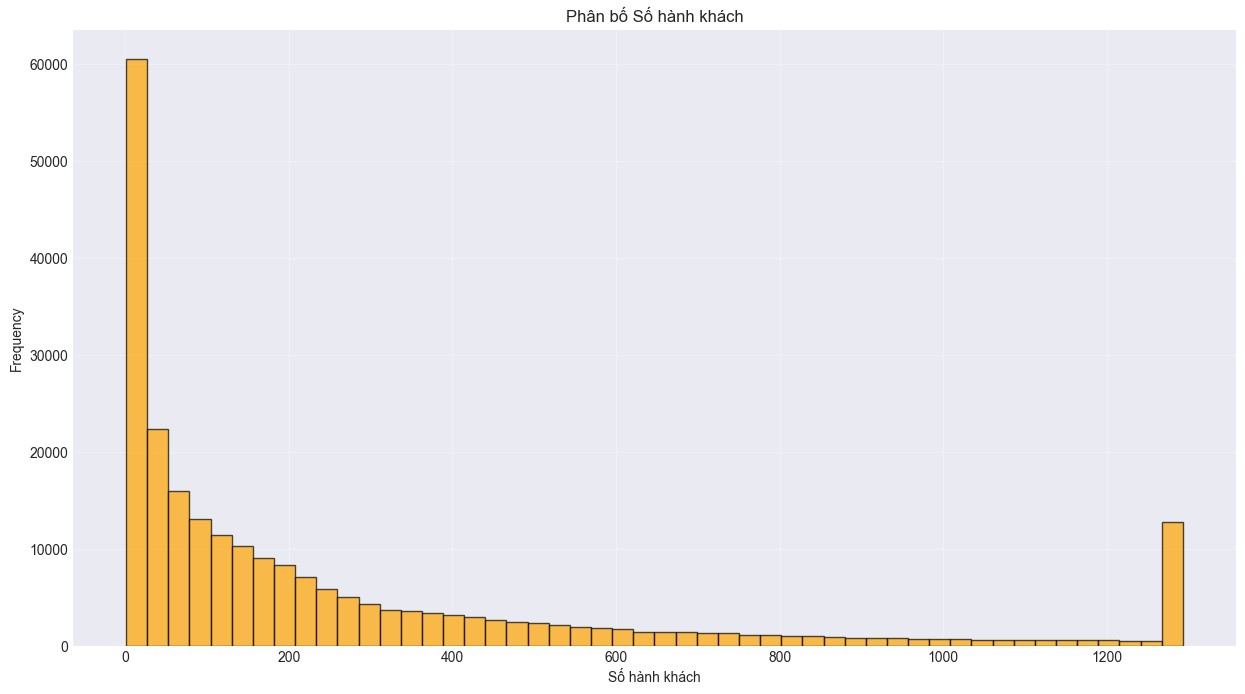

In [131]:
# 9. Phân bố số hành khách
if 'passengers' in df.columns:
    plt.figure(figsize=(15, 8))
    plt.hist(df['passengers'], bins=50, edgecolor='black', alpha=0.7, color='orange')
    plt.xlabel('Số hành khách')
    plt.ylabel('Frequency')
    plt.title('Phân bố Số hành khách')
    plt.grid(True, alpha=0.3)

In [132]:
# ==================== 4. CHUẨN BỊ DỮ LIỆU CHO MODEL ====================
print("\n" + "="*80)
print("BƯỚC 3: CHUẨN BỊ DỮ LIỆU CHO MODEL")
print("="*80)

# Tạo biến mục tiêu: thị phần
if 'large_ms' in df.columns:
    target = 'large_ms'
else:
    target = 'lf_ms'
    
print(f"\nBiến mục tiêu: {target}")

# Chọn features
feature_cols = []

# Numerical features
num_features = ['Year', 'quarter', 'passengers', 'fare', 'nsmiles', 
                'fare_lg', 'fare_low', 'lf_ms']
for col in num_features:
    if col in df.columns and col != target:
        feature_cols.append(col)

# Categorical features cần encode
cat_features = ['carrier_lg', 'carrier_low', 'city1', 'city2', 
                'airport_1', 'airport_2']

# Label Encoding cho categorical features
label_encoders = {}
for col in cat_features:
    if col in df.columns:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        feature_cols.append(f'{col}_encoded')
        print(f"  - Encoded {col}: {len(le.classes_)} categories")


BƯỚC 3: CHUẨN BỊ DỮ LIỆU CHO MODEL

Biến mục tiêu: large_ms
  - Encoded carrier_lg: 64 categories
  - Encoded carrier_low: 69 categories
  - Encoded city1: 141 categories
  - Encoded city2: 128 categories
  - Encoded airport_1: 180 categories
  - Encoded airport_2: 164 categories


In [133]:
# Feature engineering
print("\n\nTạo features mới:")

# 1. Chênh lệch giá
if 'fare' in df.columns and 'fare_low' in df.columns:
    df['fare_difference'] = df['fare'] - df['fare_low']
    feature_cols.append('fare_difference')
    print("  ✓ fare_difference")

# 2. Tỷ lệ giá
if 'fare' in df.columns and 'fare_low' in df.columns:
    df['fare_ratio'] = df['fare'] / (df['fare_low'] + 1)
    feature_cols.append('fare_ratio')
    print("  ✓ fare_ratio")

# 3. Passengers per mile
if 'passengers' in df.columns and 'nsmiles' in df.columns:
    df['passengers_per_mile'] = df['passengers'] / (df['nsmiles'] + 1)
    feature_cols.append('passengers_per_mile')
    print("  ✓ passengers_per_mile")

# 4. Revenue estimate
if 'passengers' in df.columns and 'fare' in df.columns:
    df['revenue_estimate'] = df['passengers'] * df['fare']
    feature_cols.append('revenue_estimate')
    print("  ✓ revenue_estimate")

# 5. Time features
if 'Year' in df.columns and 'quarter' in df.columns:
    df['time_period'] = df['Year'] * 4 + df['quarter']
    feature_cols.append('time_period')
    print("  ✓ time_period")

# 6. Route competition level (dựa vào lf_ms)
if 'lf_ms' in df.columns and 'lf_ms' != target:
    df['competition_level'] = 100 - df['lf_ms']
    feature_cols.append('competition_level')
    print("  ✓ competition_level")

print(f"\n\nTổng số features: {len(feature_cols)}")



Tạo features mới:
  ✓ fare_difference
  ✓ fare_ratio
  ✓ passengers_per_mile
  ✓ revenue_estimate
  ✓ time_period
  ✓ competition_level


Tổng số features: 20


In [134]:
# Chuẩn bị X và y
X = df[feature_cols].copy()
y = df[target].copy()

# Xử lý infinite và NaN values trong features mới
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Shape của X: {X.shape}")
print(f"Shape của y: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nKích thước tập train: {X_train.shape}")
print(f"Kích thước tập test: {X_test.shape}")

Shape của X: (238516, 20)
Shape của y: (238516,)

Kích thước tập train: (190812, 20)
Kích thước tập test: (47704, 20)


In [135]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [136]:
# ==================== 5. TRAIN MODELS ====================
print("\n" + "="*80)
print("BƯỚC 4: TRAIN VÀ ĐÁNH GIÁ MODELS")
print("="*80)

models = {}
predictions = {}
results = []

# 1. Linear Regression
print("\n\n1. Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
models['Linear Regression'] = lr
y_pred_lr = lr.predict(X_test_scaled)
predictions['Linear Regression'] = y_pred_lr

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"  RMSE: {rmse_lr:.4f}")
print(f"  MAE: {mae_lr:.4f}")
print(f"  R² Score: {r2_lr:.4f}")

results.append({
    'Model': 'Linear Regression',
    'RMSE': rmse_lr,
    'MAE': mae_lr,
    'R²': r2_lr
})


BƯỚC 4: TRAIN VÀ ĐÁNH GIÁ MODELS


1. Training Linear Regression...
  RMSE: 0.1758
  MAE: 0.1445
  R² Score: 0.3727


In [137]:
# 2. Random Forest
print("\n\n2. Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
models['Random Forest'] = rf
y_pred_rf = rf.predict(X_test)
predictions['Random Forest'] = y_pred_rf

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"  RMSE: {rmse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  R² Score: {r2_rf:.4f}")

results.append({
    'Model': 'Random Forest',
    'RMSE': rmse_rf,
    'MAE': mae_rf,
    'R²': r2_rf
})



2. Training Random Forest...
  RMSE: 0.0618
  MAE: 0.0343
  R² Score: 0.9224


In [138]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n  Top 10 Features quan trọng nhất:")
print(feature_importance.head(10).to_string(index=False))



  Top 10 Features quan trọng nhất:
            Feature  Importance
              lf_ms    0.558393
  competition_level    0.252638
            nsmiles    0.050476
   revenue_estimate    0.017959
passengers_per_mile    0.015746
        time_period    0.012951
  airport_2_encoded    0.010698
 carrier_lg_encoded    0.010690
  airport_1_encoded    0.009013
      city1_encoded    0.007864


In [139]:
# 3. Gradient Boosting
print("\n\n3. Training Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
gb.fit(X_train, y_train)
models['Gradient Boosting'] = gb
y_pred_gb = gb.predict(X_test)
predictions['Gradient Boosting'] = y_pred_gb

mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"  RMSE: {rmse_gb:.4f}")
print(f"  MAE: {mae_gb:.4f}")
print(f"  R² Score: {r2_gb:.4f}")

results.append({
    'Model': 'Gradient Boosting',
    'RMSE': rmse_gb,
    'MAE': mae_gb,
    'R²': r2_gb
})




3. Training Gradient Boosting...
  RMSE: 0.0713
  MAE: 0.0429
  R² Score: 0.8967


In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid các tham số cần thử
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',  # minimize RMSE
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("\nBest params for Random Forest:", grid_rf.best_params_)
print("Best RMSE:", -grid_rf.best_score_)
best_rf = grid_rf.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
gb = GradientBoostingRegressor(random_state=42)

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)

print("\nBest params for Gradient Boosting:", grid_gb.best_params_)
print("Best RMSE:", -grid_gb.best_score_)
best_gb = grid_gb.best_estimator_

In [ ]:
bins = [0, 0.4, 0.7, 1.0]  # Low <0.4, Medium 0.4-0.7, High >0.7
labels = [0, 1, 2]  # Low=0, Medium=1, High=2
y_class = pd.cut(y, bins=bins, labels=labels)

In [ ]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train_c, y_train_c)
y_pred_xgb = xgb_model.predict(X_test_c)

In [ ]:
# ==================== 6. SO SÁNH MODELS ====================
print("\n" + "="*80)
print("BƯỚC 5: SO SÁNH VÀ LỰA CHỌN MODEL TỐT NHẤT")
print("="*80)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False)
print("\n\nBảng so sánh các models:")
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
print(f"\n\n🏆 Model tốt nhất: {best_model_name}")
print(f"   - RMSE: {results_df.iloc[0]['RMSE']:.4f}")
print(f"   - MAE: {results_df.iloc[0]['MAE']:.4f}")
print(f"   - R² Score: {results_df.iloc[0]['R²']:.4f}")



BƯỚC 5: SO SÁNH VÀ LỰA CHỌN MODEL TỐT NHẤT


Bảng so sánh các models:
            Model     RMSE      MAE       R²
    Random Forest 0.061842 0.034334 0.922404
Gradient Boosting 0.071339 0.042862 0.896742
Linear Regression 0.175836 0.144488 0.372689


🏆 Model tốt nhất: Random Forest
   - RMSE: 0.0618
   - MAE: 0.0343
   - R² Score: 0.9224


In [ ]:
# ==================== 8. DỰ ĐOÁN MẪU ====================
print("\n" + "="*80)
print("BƯỚC 6: VÍ DỤ DỰ ĐOÁN")
print("="*80)

# Lấy 10 mẫu ngẫu nhiên từ test set
sample_predictions = X_test.head(10).copy()
sample_actual = y_test.head(10).copy()

best_model = models[best_model_name]
if best_model_name == 'Linear Regression':
    sample_pred = best_model.predict(scaler.transform(sample_predictions))
else:
    sample_pred = best_model.predict(sample_predictions)

comparison = pd.DataFrame({
    'Actual_Market_Share': sample_actual.values,
    'Predicted_Market_Share': sample_pred,
    'Error': sample_actual.values - sample_pred,
    'Error_%': ((sample_actual.values - sample_pred) / sample_actual.values * 100)
})

print(f"\n\nMẫu dự đoán sử dụng {best_model_name}:")
print(comparison.to_string())


BƯỚC 6: VÍ DỤ DỰ ĐOÁN


Mẫu dự đoán sử dụng Random Forest:
   Actual_Market_Share  Predicted_Market_Share         Error       Error_%
0               0.8300                0.830000  3.330669e-16  4.012854e-14
1               0.7900                0.854680 -6.467966e-02 -8.187298e+00
2               0.6300                0.486713  1.432869e-01  2.274396e+01
3               0.9700                0.970000 -1.465494e-14 -1.510819e-12
4               0.2500                0.315364 -6.536429e-02 -2.614572e+01
5               0.8200                0.644960  1.750400e-01  2.134634e+01
6               0.7826                0.782591  9.323873e-06  1.191397e-03
7               1.0000                1.000000  0.000000e+00  0.000000e+00
8               0.6400                0.608762  3.123846e-02  4.881010e+00
9               0.6900                0.690000  1.776357e-15  2.574430e-13
